# Growth curve analysis of validation mutants

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["svg.fonttype"] = "none"

## Specify paths

In [2]:
growth_data_path = "../growth_data/"
layout_path = "20250404_test3_layout.txt"
source_data = [
    "20250404_mutants_hors_HS_test3_ctrl-cas.xlsx",
    "20250404_mutants_hors_HS_test3_mic-ani.xlsx",
]
graph_outpath = "../graphs/"

## Get layout

In [3]:
layout = pd.read_csv(f"{growth_data_path}/{layout_path}", sep="\t", header=0)
layout

,plate,well,compound,genotype,clone,group,position
0,1,A1,none,E635R,3.0,mutant,635
1,1,B1,none,E635R,7.0,mutant,635
2,1,C1,none,E635S,2.0,mutant,635
3,1,D1,none,E635S,3.0,mutant,635
4,1,E1,none,E635V,2.0,mutant,635
...,...,...,...,...,...,...,...
187,2,D12,anidulafungin,F639D,3.0,HS1_mutant,639
188,2,E12,anidulafungin,R645D,1.0,HS1_mutant,645
189,2,F12,anidulafungin,R645D,2.0,HS1_mutant,645
190,2,G12,anidulafungin,R645D,3.0,HS1_mutant,645


## Get plate reader data

In [4]:
def get_data(fpath):
    ### Import libraries
    import numpy as np
    from datetime import datetime, date, time

    ### Read excel file
    source_df = pd.read_excel(fpath, index_col=0, header=0, skiprows=25, skipfooter=111)

    ### Parse timepoints
    t0, t1 = source_df.iloc[[0, 1], 0]  # Get the first and second timepoints

    # Convert first timepoint from time (of the day) object to time duration (h)
    t0_h = (
        datetime.combine(date.today(), t0) - datetime.combine(date.today(), time.min)
    ).total_seconds() / 3600

    # Convert difference between second and first timepoint into duration in h (measurement interval)
    delta = (
        datetime.combine(date.today(), t1) - datetime.combine(date.today(), t0)
    ).total_seconds() / 3600

    # Rewrite column of timepoints using calculated values
    source_df["Time"] = np.arange(t0_h, t0_h + len(source_df.Time) * delta, delta)

    # Delete column with temperature
    source_df.drop(columns="T° 600", inplace=True)

    # Rename columns
    source_df.columns = [x.split("=")[-1] if "=" in x else x for x in source_df.columns]

    # Reshape
    longdf = source_df.melt(
        id_vars="Time", var_name="well", value_name="OD"
    )  # wide to long dataframe
    return longdf

In [5]:
df_list = []

for i, f in enumerate(source_data):
    df = get_data(f"{growth_data_path}/{f}")
    df["plate"] = i + 1
    df_list.append(df)

fulldf = pd.concat(df_list, ignore_index=True)
fulldf

,Time,well,OD,plate
0,0.00,A1,0.113,1
1,0.25,A1,0.098,1
2,0.50,A1,0.098,1
3,0.75,A1,0.098,1
4,1.00,A1,0.099,1
...,...,...,...,...
22651,28.25,H12,0.091,2
22652,28.50,H12,0.091,2
22653,28.75,H12,0.091,2
22654,29.00,H12,0.091,2


## Annotate data

In [6]:
annotdf = fulldf.merge(right=layout, on=["plate", "well"])
annotdf

,Time,well,OD,plate,compound,genotype,clone,group,position
0,0.00,A1,0.113,1,none,E635R,3.0,mutant,635
1,0.25,A1,0.098,1,none,E635R,3.0,mutant,635
2,0.50,A1,0.098,1,none,E635R,3.0,mutant,635
3,0.75,A1,0.098,1,none,E635R,3.0,mutant,635
4,1.00,A1,0.099,1,none,E635R,3.0,mutant,635
...,...,...,...,...,...,...,...,...,...
22651,28.25,H12,0.091,2,anidulafungin,NaN,NaN,NaN,NaN
22652,28.50,H12,0.091,2,anidulafungin,NaN,NaN,NaN,NaN
22653,28.75,H12,0.091,2,anidulafungin,NaN,NaN,NaN,NaN
22654,29.00,H12,0.091,2,anidulafungin,NaN,NaN,NaN,NaN


## Visualize growth curves

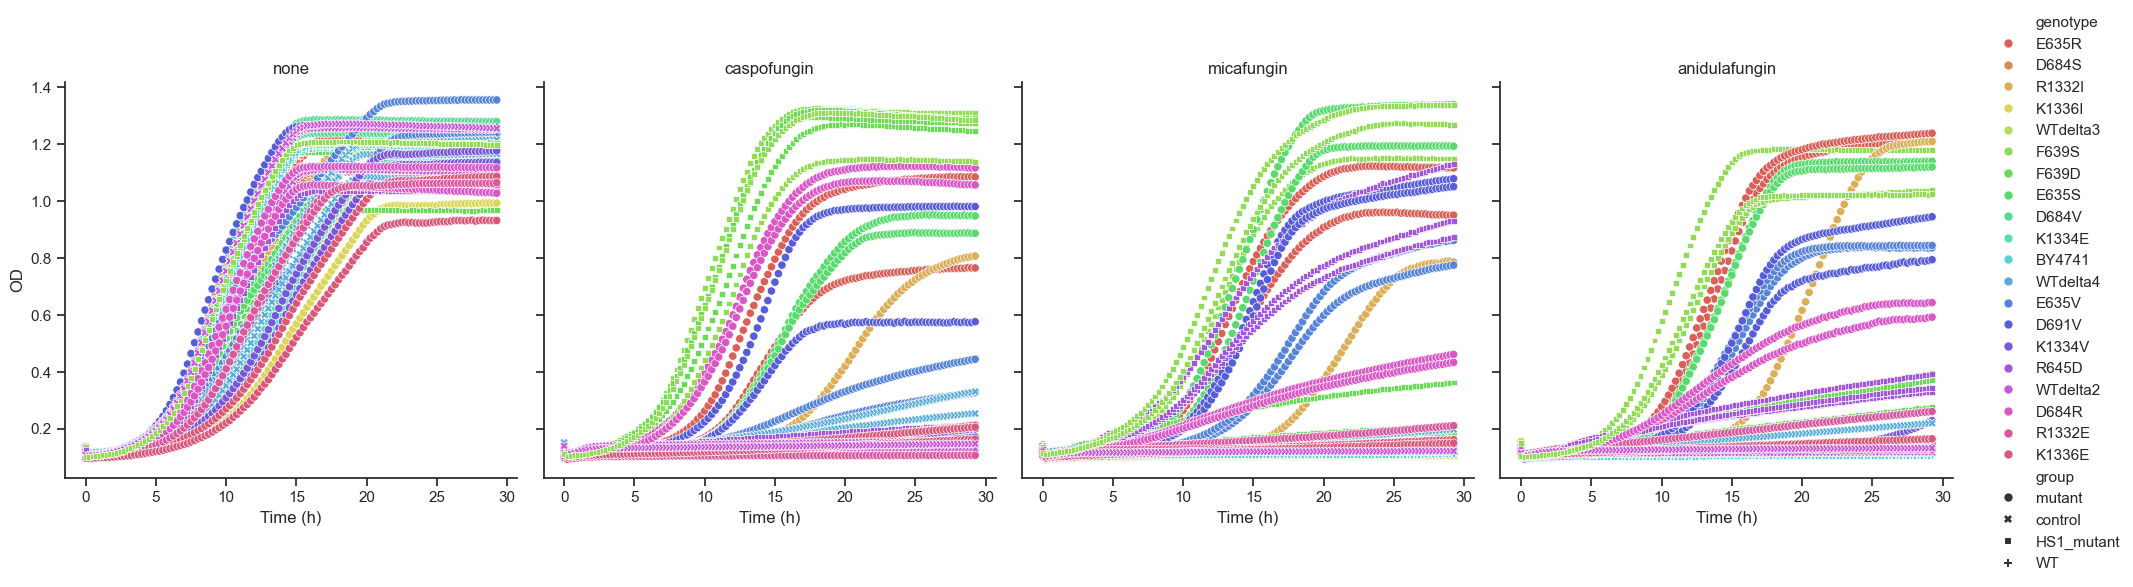

In [7]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

grid = sns.relplot(
    data=annotdf,
    x="Time",
    y="OD",
    col="compound",
    hue="genotype",
    palette="hls",
    style="group",
)

grid.set_titles(row_template="{row_name}", col_template="{col_name}")
grid.set_axis_labels("Time (h)", "OD")
grid.tight_layout()

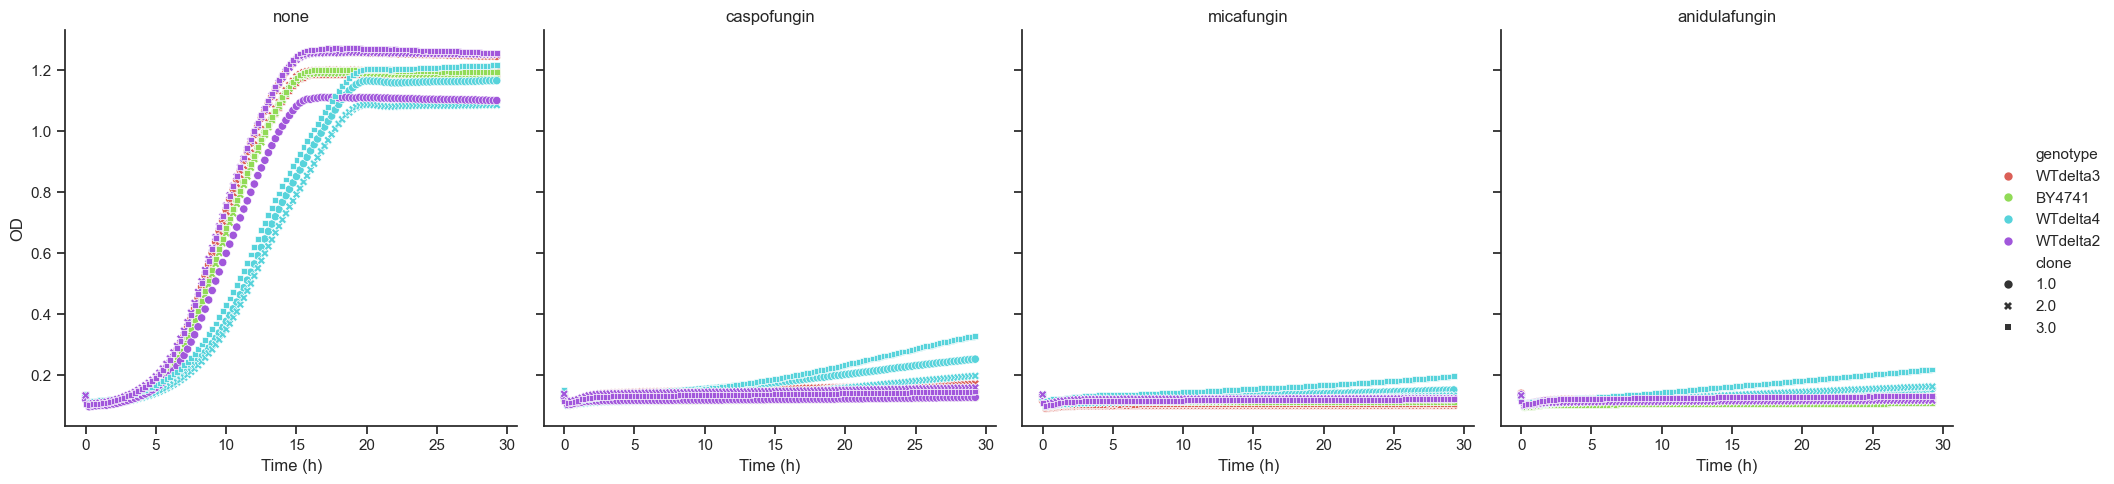

In [8]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

grid = sns.relplot(
    data=annotdf[annotdf.group.isin(["WT", "control"])],
    x="Time",
    y="OD",
    col="compound",
    hue="genotype",
    palette="hls",
    style="clone",
)

grid.set_titles(row_template="{row_name}", col_template="{col_name}")
grid.set_axis_labels("Time (h)", "OD")
grid.tight_layout()

## Calculate normalized area under the curve (AUC)

In [9]:
def get_auc(g):
    import numpy as np

    return np.trapezoid(g.OD)

In [10]:
aucdf = (
    annotdf[annotdf["Time"] <= 25]
    .groupby(["group", "genotype", "position", "clone", "compound", "well"])[["OD"]]
    .apply(func=get_auc)
    .reset_index(name="auc")
)
aucdf

,group,genotype,position,clone,compound,well,auc
0,HS1_mutant,F639D,639,1.0,anidulafungin,B12,23.3610
1,HS1_mutant,F639D,639,1.0,caspofungin,B12,75.1860
2,HS1_mutant,F639D,639,1.0,micafungin,B6,15.4750
3,HS1_mutant,F639D,639,1.0,none,B6,60.5285
4,HS1_mutant,F639D,639,2.0,anidulafungin,C12,22.6260
...,...,...,...,...,...,...,...
183,mutant,R1332I,1332,1.0,none,A3,55.8500
184,mutant,R1332I,1332,2.0,anidulafungin,B9,33.1830
185,mutant,R1332I,1332,2.0,caspofungin,B9,25.1650
186,mutant,R1332I,1332,2.0,micafungin,B3,22.7075


In [11]:
aggdf = (
    aucdf.groupby(["group", "genotype", "position", "compound"])[["auc"]]
    .agg(auc=("auc", "mean"), auc_min=("auc", "min"), auc_max=("auc", "max"))
    .reset_index()
)
aggdf.head(10)

,group,genotype,position,compound,auc,auc_min,auc_max
0,HS1_mutant,F639D,639,anidulafungin,21.297500,17.9055,23.3610
1,HS1_mutant,F639D,639,caspofungin,79.084500,75.1860,81.5680
2,HS1_mutant,F639D,639,micafungin,18.134833,14.6435,24.2860
3,HS1_mutant,F639D,639,none,71.981167,60.5285,78.8550
4,HS1_mutant,F639S,639,anidulafungin,65.015833,59.8890,73.6460
5,HS1_mutant,F639S,639,caspofungin,76.889333,67.0065,83.3155
6,HS1_mutant,F639S,639,micafungin,68.645333,63.1625,74.6270
7,HS1_mutant,F639S,639,none,78.037833,76.4890,78.8810
8,HS1_mutant,R645D,645,anidulafungin,22.856667,21.7580,24.5255
9,HS1_mutant,R645D,645,caspofungin,14.245667,12.7770,16.2860


In [12]:
aggdf[aggdf.group.isin(["WT", "control"])]

,group,genotype,position,compound,auc,auc_min,auc_max
12,WT,BY4741,ctrl,anidulafungin,10.769500,10.5180,10.9480
13,WT,BY4741,ctrl,caspofungin,12.407833,11.7560,13.3785
14,WT,BY4741,ctrl,micafungin,11.215667,11.0005,11.5365
15,WT,BY4741,ctrl,none,76.828000,76.3525,77.2060
16,control,WTdelta2,ctrl,anidulafungin,12.000833,11.3495,12.5450
17,control,WTdelta2,ctrl,caspofungin,13.354333,11.9785,14.5745
18,control,WTdelta2,ctrl,micafungin,12.011333,11.7125,12.2405
19,control,WTdelta2,ctrl,none,78.473000,70.6985,82.5830
20,control,WTdelta3,ctrl,anidulafungin,12.118833,11.9340,12.4735
21,control,WTdelta3,ctrl,caspofungin,13.909167,13.2310,15.1720


In [13]:
def get_l2fc(val, minv, maxv, comp, df):
    import numpy as np

    # Retrieve corresponding WT value for the condition
    wt = df.loc[(df.compound == comp) & (df.group == "WT"), "auc"].values

    # Make sure a single value was extracted
    if len(wt) == 1:
        # Return log2 fold-change for mean, min and max
        return np.log2(val / wt[0]), np.log2(minv / wt[0]), np.log2(maxv / wt[0])
    else:
        return "error"

In [14]:
aggdf["L2FC"], aggdf["L2FC_min"], aggdf["L2FC_max"] = zip(
    *aggdf.apply(
        lambda row: get_l2fc(row.auc, row.auc_min, row.auc_max, row.compound, aggdf),
        axis=1,
    )
)
aggdf.head(10)

,group,genotype,position,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max
0,HS1_mutant,F639D,639,anidulafungin,21.297500,17.9055,23.3610,0.983733,0.733452,1.117151
1,HS1_mutant,F639D,639,caspofungin,79.084500,75.1860,81.5680,2.672144,2.599213,2.716752
2,HS1_mutant,F639D,639,micafungin,18.134833,14.6435,24.2860,0.693248,0.384745,1.114610
3,HS1_mutant,F639D,639,none,71.981167,60.5285,78.8550,-0.094013,-0.344018,0.037570
4,HS1_mutant,F639S,639,anidulafungin,65.015833,59.8890,73.6460,2.593840,2.475340,2.773656
5,HS1_mutant,F639S,639,caspofungin,76.889333,67.0065,83.3155,2.631532,2.433050,2.747334
6,HS1_mutant,F639S,639,micafungin,68.645333,63.1625,74.6270,2.613646,2.493553,2.734182
7,HS1_mutant,F639S,639,none,78.037833,76.4890,78.8810,0.022542,-0.006380,0.038046
8,HS1_mutant,R645D,645,anidulafungin,22.856667,21.7580,24.5255,1.085664,1.014595,1.187331
9,HS1_mutant,R645D,645,caspofungin,14.245667,12.7770,16.2860,0.199272,0.042298,0.392381


In [15]:
aggdf["min_yerr"] = aggdf["L2FC"] - aggdf["L2FC_min"]
aggdf["max_yerr"] = aggdf["L2FC_max"] - aggdf["L2FC"]
aggdf.head(10)

,group,genotype,position,compound,auc,auc_min,auc_max,L2FC,L2FC_min,L2FC_max,min_yerr,max_yerr
0,HS1_mutant,F639D,639,anidulafungin,21.297500,17.9055,23.3610,0.983733,0.733452,1.117151,0.250281,0.133418
1,HS1_mutant,F639D,639,caspofungin,79.084500,75.1860,81.5680,2.672144,2.599213,2.716752,0.072931,0.044608
2,HS1_mutant,F639D,639,micafungin,18.134833,14.6435,24.2860,0.693248,0.384745,1.114610,0.308503,0.421361
3,HS1_mutant,F639D,639,none,71.981167,60.5285,78.8550,-0.094013,-0.344018,0.037570,0.250005,0.131583
4,HS1_mutant,F639S,639,anidulafungin,65.015833,59.8890,73.6460,2.593840,2.475340,2.773656,0.118500,0.179816
5,HS1_mutant,F639S,639,caspofungin,76.889333,67.0065,83.3155,2.631532,2.433050,2.747334,0.198482,0.115801
6,HS1_mutant,F639S,639,micafungin,68.645333,63.1625,74.6270,2.613646,2.493553,2.734182,0.120093,0.120536
7,HS1_mutant,F639S,639,none,78.037833,76.4890,78.8810,0.022542,-0.006380,0.038046,0.028921,0.015504
8,HS1_mutant,R645D,645,anidulafungin,22.856667,21.7580,24.5255,1.085664,1.014595,1.187331,0.071069,0.101668
9,HS1_mutant,R645D,645,caspofungin,14.245667,12.7770,16.2860,0.199272,0.042298,0.392381,0.156974,0.193109


## Visualize log2 fold changes

In [16]:
from matplotlib import colors

genotypes = [
    "BY4741",
    "WTdelta2",
    "WTdelta3",
    "WTdelta4",
    "F639S",
    "F639D",
    "R645D",
    "E635S",
    "E635V",
    "E635R",
    "D684R",
    "D684S",
    "D684V",
    "D691V",
    "R1332E",
    "R1332I",
    "K1334E",
    "K1334V",
    "K1336E",
    "K1336I",
]

lcomp = ["none", "anidulafungin", "caspofungin", "micafungin"]
comp_dict = {
    "caspofungin": "Caspofungin",
    "micafungin": "Micafungin",
    "anidulafungin": "Anidulafungin",
    "none": "Control",
}

pos = ["ctrl", 639, 645, 635, 684, 691, 1332, 1334, 1336]
pos_palette = [colors.to_hex("lightgrey")] + sns.color_palette("hls", 8).as_hex()

In [17]:
print(sns.color_palette("hls", 8).as_hex())

['#db5f57', '#dbc257', '#91db57', '#57db80', '#57d3db', '#5770db', '#a157db', '#db57b2']


In [18]:
sort_dic = dict(zip(list(genotypes), list(range(0, len(genotypes)))))
# pos_cmap = dict(zip(pos, pos_palette)) need individual colors
# quick fix
pos_cmap = (
    ["lightgrey"] * 4
    + ["#db5f57"] * 2
    + ["#dbc257"]
    + ["#91db57"] * 3
    + ["#57db80"] * 3
    + ["#57d3db"]
    + ["#5770db"] * 2
    + ["#a157db"] * 2
    + ["#db57b2"] * 2
)

In [19]:
aggdf.sort_values(by="genotype", key=lambda x: x.map(sort_dic), inplace=True)

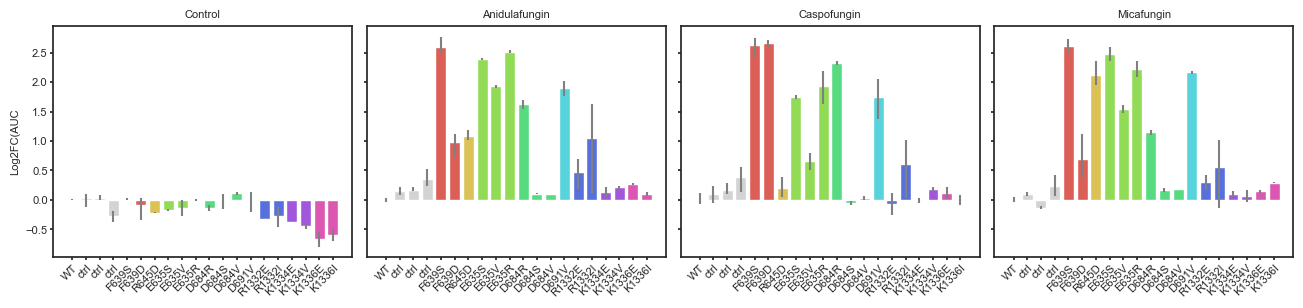

In [20]:
sns.set_theme(
    rc={
        "font.family": "Arial",
        "font.size": 8,
        "legend.title_fontsize": 8,
        "legend.fontsize": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "xtick.major.pad": 2,
        "ytick.major.pad": 2,
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.major.size": 2,
        "ytick.major.size": 2,
    },
    style="white",
)

fig, ax = plt.subplots(
    ncols=4, sharey=True, figsize=(16, 3), gridspec_kw={"wspace": 0.05}
)

for i, c in enumerate(lcomp):
    graphdf = aggdf[aggdf.compound == c]
    ax[i].title.set_text(comp_dict[c])

    # Drar bars
    ax[i].bar(
        x=graphdf.genotype,
        height=graphdf.L2FC,
        yerr=[graphdf.min_yerr, graphdf.max_yerr],
        color=pos_cmap,
        ecolor="grey",
    )

    # Decorate
    ax[i].set_xticks(
        ticks=np.arange(len(genotypes)),
        labels=[
            "WT",
            "ctrl",
            "ctrl",
            "ctrl",
            "F639S",
            "F639D",
            "R645D",
            "E635S",
            "E635V",
            "E635R",
            "D684R",
            "D684S",
            "D684V",
            "D691V",
            "R1332E",
            "R1332I",
            "K1334E",
            "K1334V",
            "K1336E",
            "K1336I",
        ],
        rotation=45,
        ha="right",
        rotation_mode="anchor",
    )

ax[0].set(ylabel="Log2FC(AUC")

plt.savefig(graph_outpath + "mutants_out_HS.svg", format="svg", dpi=300)